# Australian Ocean Surface Wave Measurements from SAR

|  |  |
| ----------- | ----------- |
| Author:| Salman Khan, Emilio Echevarria |
| Edited:| Benjamin Stepin |
| Affiliation:| CSIRO, IMOS |
| e-mail:| salmansaeed.khan@csiro.au, info@aodn.org.au |
| Date of creation:| 5th Mar., 2020|
| Date of last update:| 29th Apr., 2024 |


## Table of contents:

1. [About Sentinel-1  Ocean Surface Wave Measurements](#1-background-about-sentinel-1-ocean-surface-wave-measurements)
2. [Required Python Packages](#2-required-python-packages)
3. [Read a daily along-track netCDF file and visualise selected measurements off Albany, WA on a map](#3-read-a-daily-along-track-netcdf-file-and-visualise-selected-measurements-off-albany-wa-on-a-map)
4. [Plot some auxialliary variables as the satellite measures along-track](#4-plot-some-auxialliary-variables-as-the-satellite-measures-along-track)
5. [Convert directional wavenumber spectra to frequency spectra using deep water assumptions](#5-convert-directional-wavenumber-spectra-to-frequency-spectra-using-deep-water-assumptions)
6. [Plot some wave statistics derived from directional frequency spectra](#6-plot-some-wave-statistics-derived-from-directional-frequency-spectra)
7. [Visualise directional frequency spectra: (i) one, (ii) all 2D, and (iii) all 1D](#7-visualise-directional-frequency-spectra)
8. [Visualise directional frequency spectra swell partitions: (i) one, (ii) all](#8-visualise-directional-frequency-spectra-swell-partitions)
9. [Plot some primary swell partitions wave statistics](#9-plot-some-primary-swell-wave-statistics)

### 1. Background: About Sentinel-1 Ocean Surface Wave Measurements
Sentinel-1 A and B satellites, part of Europe’s Copernicus programme, were launched in April 2014 and 2016, respectively. The satellites fly in the same polar orbital plane, but 180° out of orbital phase, and offer a 6-day repeat cycle at the equator and more frequently at higher latitudes. Both satellites are equipped with identical C-band SAR instruments, which can measure the directional wind-wave spectra for wavelengths longer than ~150m in azimuth direction. In the open ocean, they operate in wave mode (WV), measuring alternately in near-range with an incidence angle of ~23.5° (WV1) and far-range with an incidence angle of ~36.5° (WV2), and acquire 20 km x 20 km vignettes every 100 km along-track. Since they alternate between WV1 and WV2, consecutive vignettes for each incidence angle are 200 km apart. The transmit-receive electromagnetic polarisation pair of choice in wave mode is VV, but some experimental HH data have also been acquired.

This dataset contains Sentinel-1 A and B SAR measurements over the Asutralasian region. The data is accesible through the AODN portal (https://portal.aodn.org.au/), or http://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/Surface-Waves/SAR/catalog.html

The amount of data for each sattelite (A and B) for different wave modes (WV1 and WV2) and orbit's direction (ascending or descending passes), allocated in 2.5°x2.5° bins:

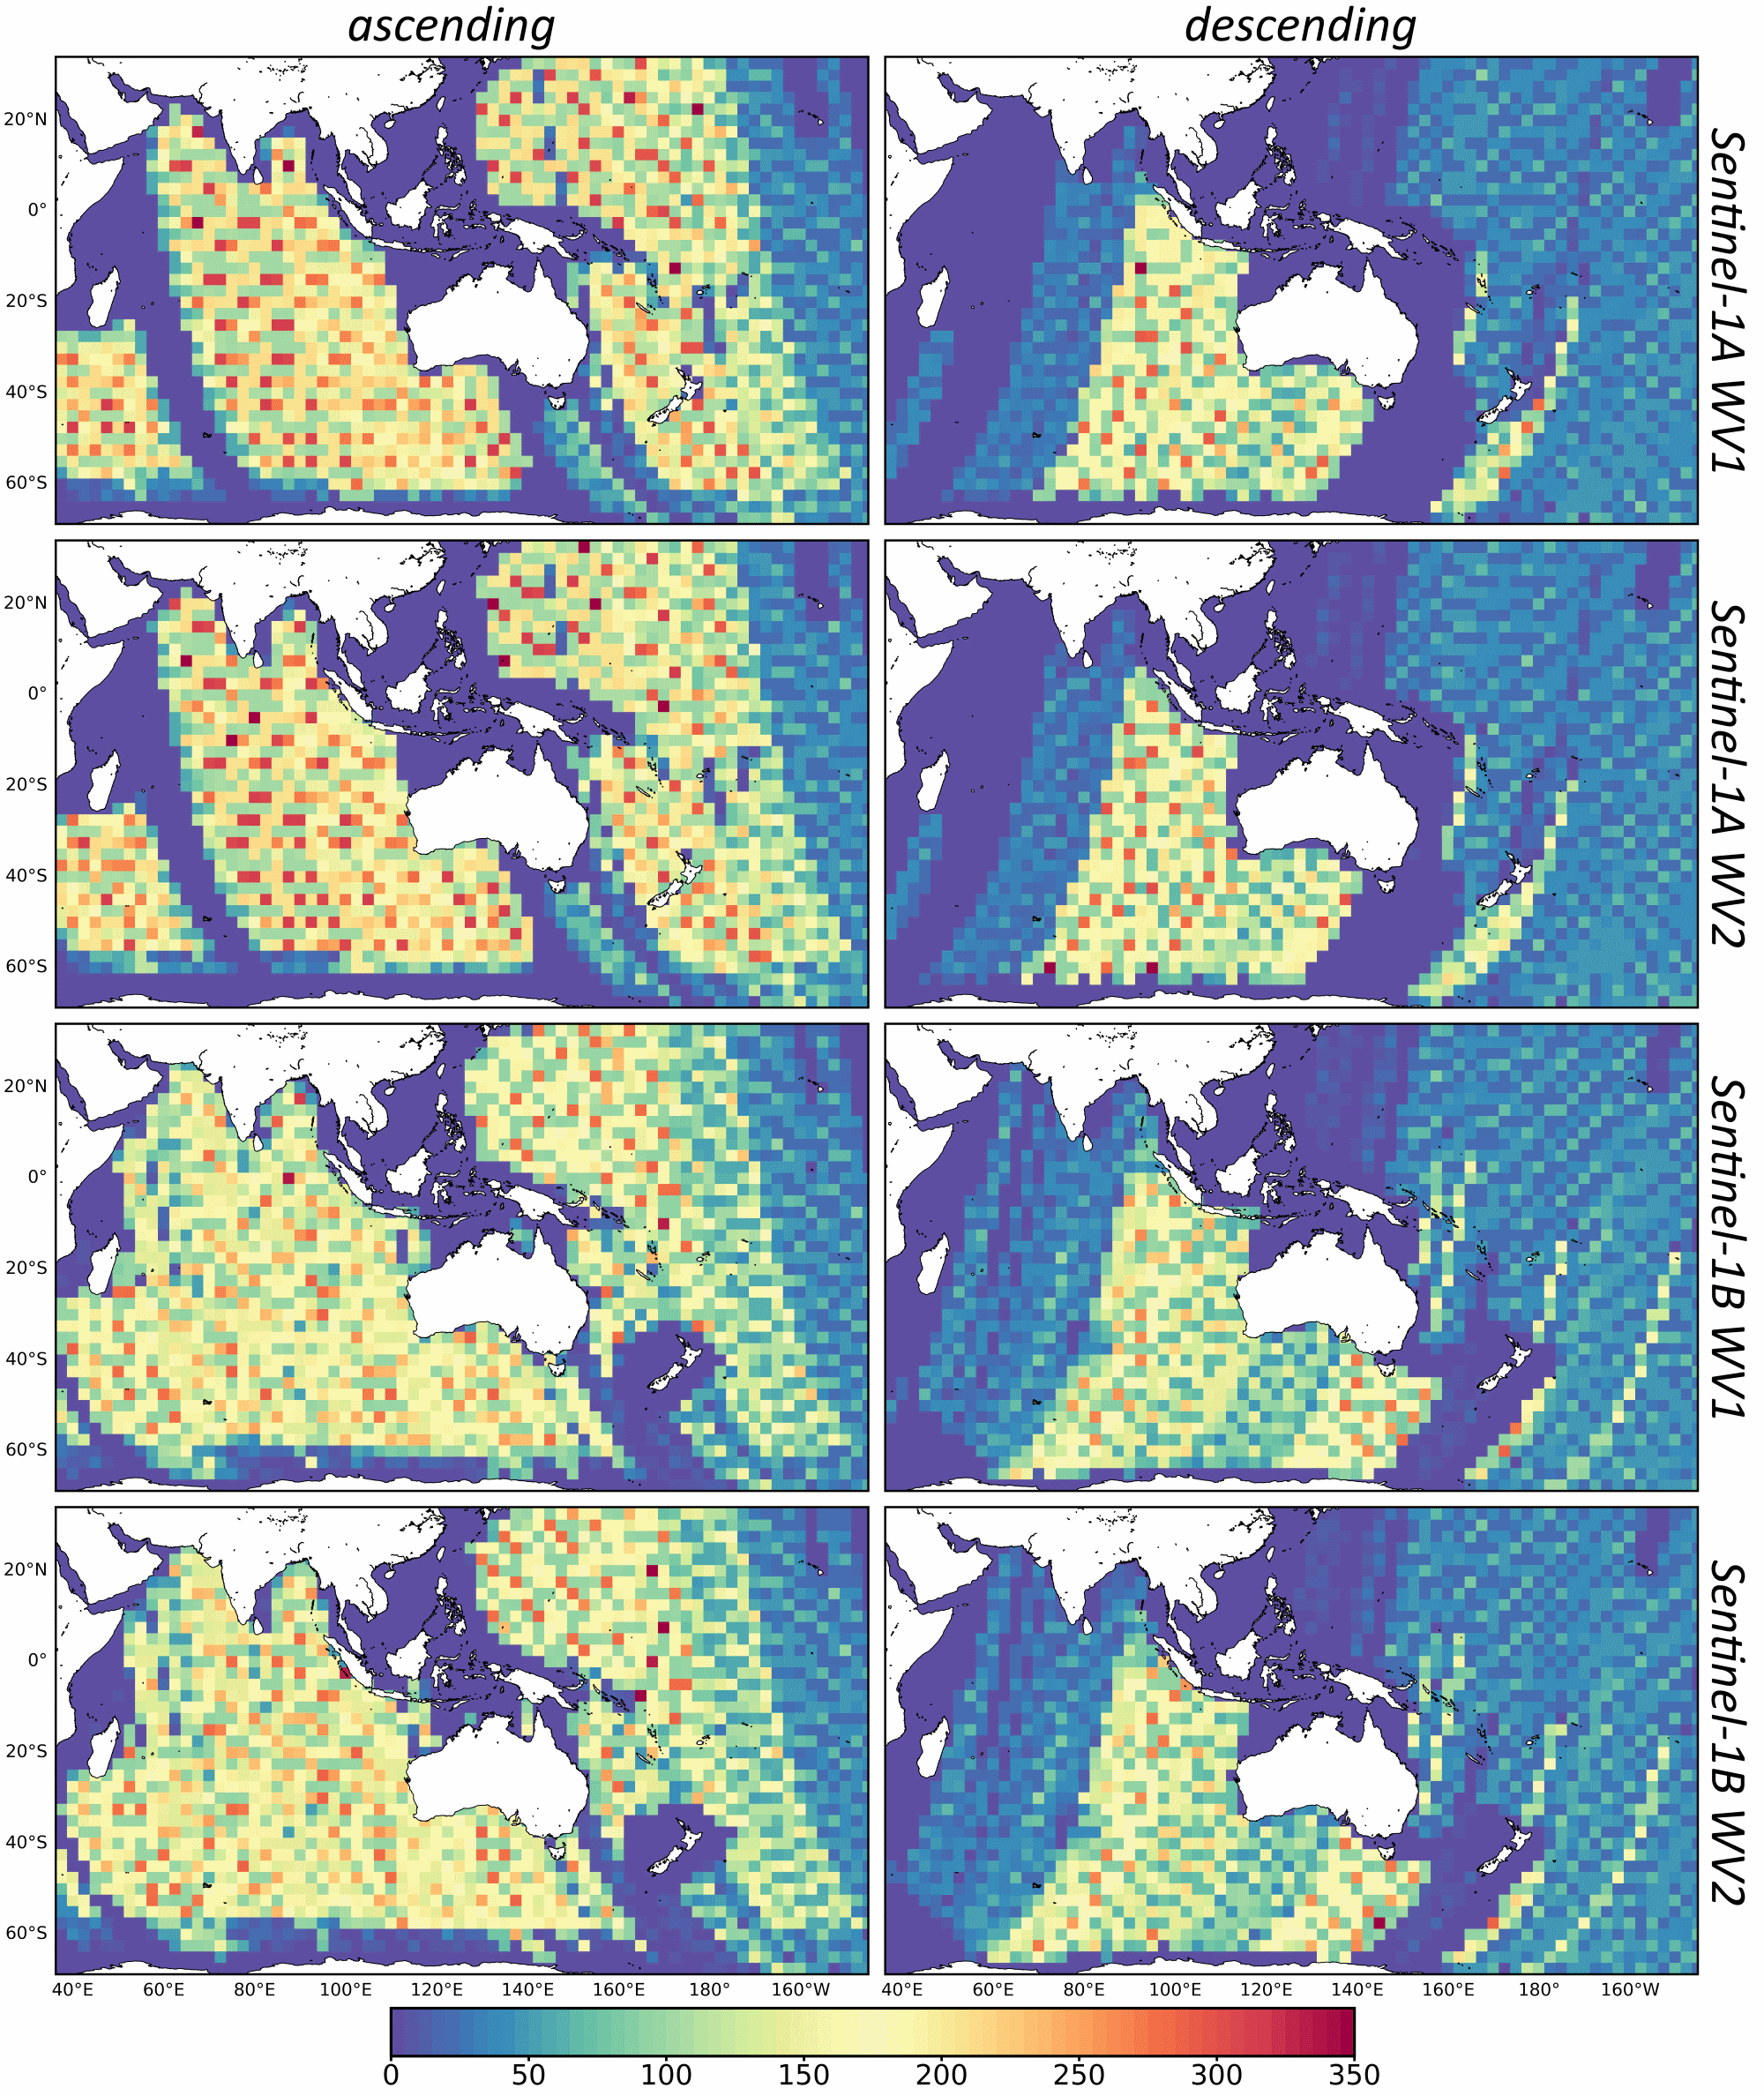

### 2. Required Python packages

- Python <= 3.10
- cartopy = 0.16.0
- matplotlib = 2.2.2
- numpy = 1.15.0
- xarray = 0.11.3
- utility functions from utilfuncs.py 

#### Secondary dependancies
- netcdf4 = 1.6.5
- pydap = 3.4.1
- wavespectra = 3.5.3 (Note wavespectra is currently only compatible with Python version 3.11 and below, also requires Fortran Compiler)

In [1]:
# Run this code to install the required packages
# !pip install cartopy==0.16.0 matplotlib==2.2.2 numpy==1.15.0 xarray==0.11.3 netcdf4==1.6.5 pydap==3.4.1 wavespectra==3.5.3


In [2]:
%reset -f
%matplotlib widget

import os
import sys
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

from utilfuncs import k2f, ek2f, s1_compute_efth, cmap_wavespectra, plot_part

warnings.filterwarnings('ignore')

### 3. Read a daily along-track netCDF file and visualise selected measurements off Albany, WA on a map

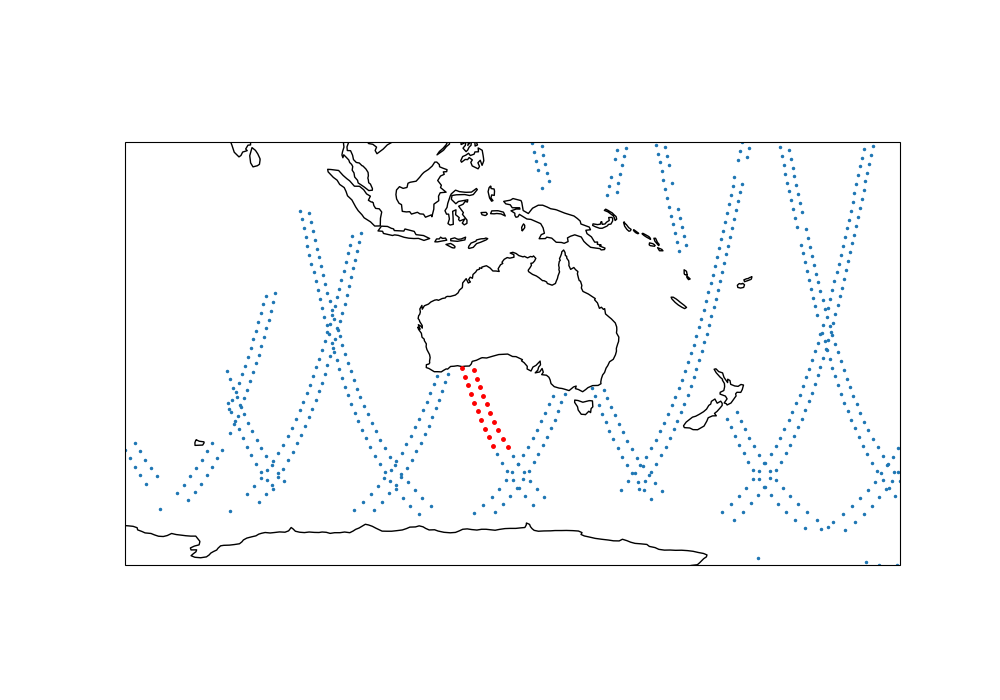

In [3]:
# read and select measurements near South Australia
dset_s1 = xr.open_dataset('https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR/DELAYED/SENTINEL-1A/2023/10/IMOS_SRS-Surface-Waves_W_20231012T000006Z_Sentinel-1A_FV01_DM00_K2_END-20231012T231504Z.nc'+'#fillmismatch',
                          decode_times=True, decode_cf=True, mask_and_scale=True)
dset_WA = dset_s1.isel(TIME=slice(225, 245))

# Calculate extent of the data in lat and lon
min_lon, max_lon = np.amin(dset_s1.LONGITUDE[dset_s1.LONGITUDE > 0]).item(), np.amax(dset_s1.LONGITUDE[dset_s1.LONGITUDE < 0]).item()
min_lat, max_lat = dset_s1.LATITUDE.min(), dset_s1.LATITUDE.max()

# Convert the long so it takes into account going over the dateline, so as not to draw the empty map extent.
max_lon = 360 + max_lon

# Create the plot with the specified longitude extent
fig = plt.figure(figsize=(10, 7), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(min_lon + max_lon) / 2))
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.coastlines()

# Plot measurement locations
ax.plot(dset_s1.LONGITUDE, dset_s1.LATITUDE, '.', transform=ccrs.PlateCarree(), markersize=3)
ax.plot(dset_WA.LONGITUDE, dset_WA.LATITUDE, 'r.', transform=ccrs.PlateCarree(), markersize=5)

plt.show()

### 4. Plot some auxialliary variables as the satellite measures along-track
- satellite heading
- incidence angle
- distance to coast, and 
- depth 

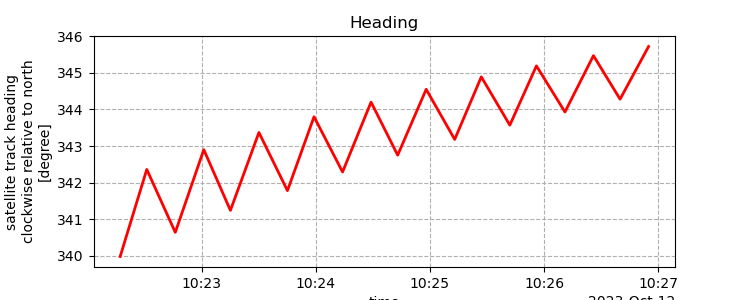

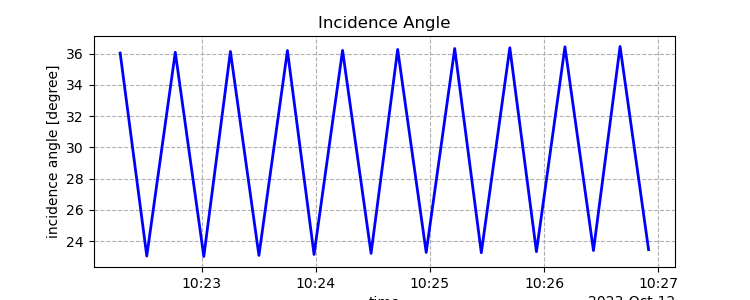

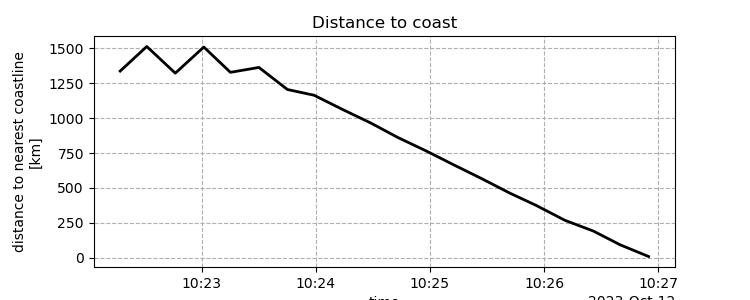

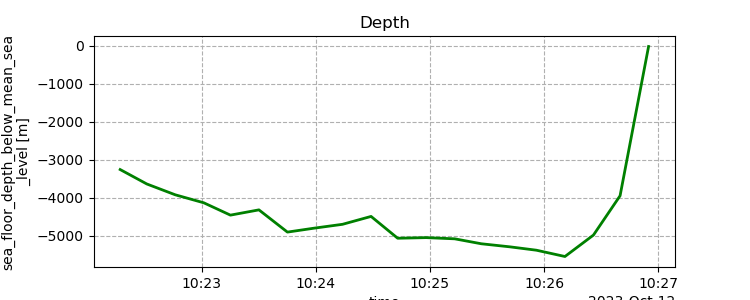

In [4]:
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.HEADING.plot(ax = ax, lw=2, c='r')
plt.title('Heading') 
plt.grid(linestyle = 'dashed')

fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.INC_ANGLE.plot(ax = ax, lw=2, c='b')
plt.title('Incidence Angle') 
plt.grid(linestyle = 'dashed')

fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.DIST2COAST.plot(ax = ax, lw=2, c='k')
plt.title('Distance to coast')
plt.grid(linestyle = 'dashed')

fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.BOT_DEPTH.plot(ax = ax, lw=2, c='g')
plt.title('Depth')
plt.grid(linestyle = 'dashed')

### 5. Convert directional wavenumber spectra to frequency spectra using deep water assumptions:
efth - spectral variance density 
- units m2.s.deg-1

In [5]:
# compute efth
dset_WA_ws = dset_WA.assign(efth = s1_compute_efth(dset_WA))


### 6. Plot some wave statistics derived from directional frequency spectra:
- swell significant height
- mean period - Tm02
- mean wave direction

A directional wave spectrum describes how the wave energy (more specifically, the variance spectral density) is distributed over frequencies (or wavenumbers) and directions. For a detailed description of wave spectra, its uses and applications, and the transformations from wavenumber to frequency spectra, see: Holthuijsen, L. (2007). Waves in Oceanic and Coastal Waters. Cambridge: Cambridge University Press. https://doi.org/10.1017/CBO9780511618536

It is very common to describe the wave climate with integrated (also called bulk) wave parameters, instead of with a directional wave spectra. These parameters represent average conditions of the wave climate. 

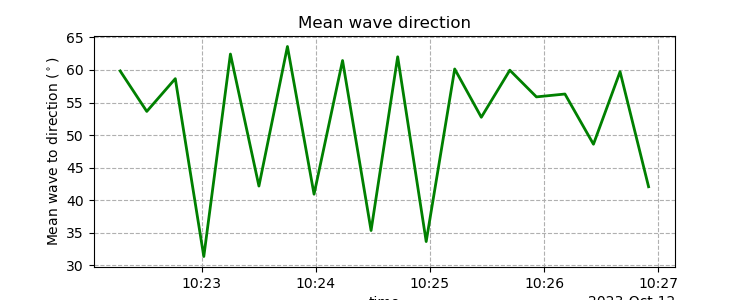

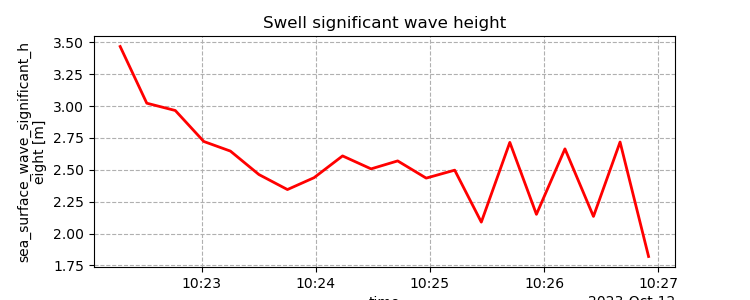

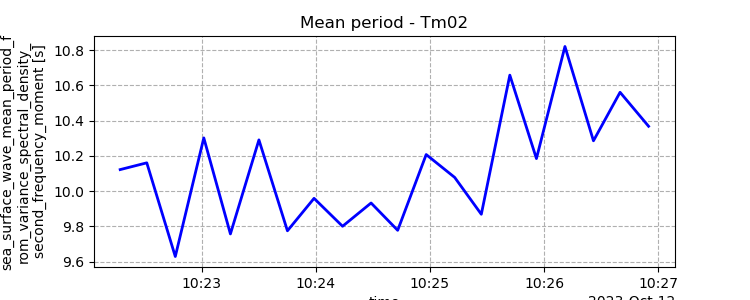

In [6]:
# plot stats
# hs
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.spec.hs(tail = True).plot(ax = ax, lw=2, c='r')
plt.title('Swell significant wave height')
plt.grid(linestyle = 'dashed')

# tm02
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.spec.tm02().plot(ax = ax, lw=2, c='b')
plt.title('Mean period - Tm02')
plt.grid(linestyle = 'dashed')

# dm
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.spec.dm().plot(ax = ax, lw=2, c='g')
plt.ylabel('Mean wave to direction $(^\circ)$')
plt.title('Mean wave direction')
plt.grid(linestyle = 'dashed')
plt.show()

### 7. Visualise directional frequency spectra:
- 1st directional spectra
- all directional spectra
- all omni-directional spectra

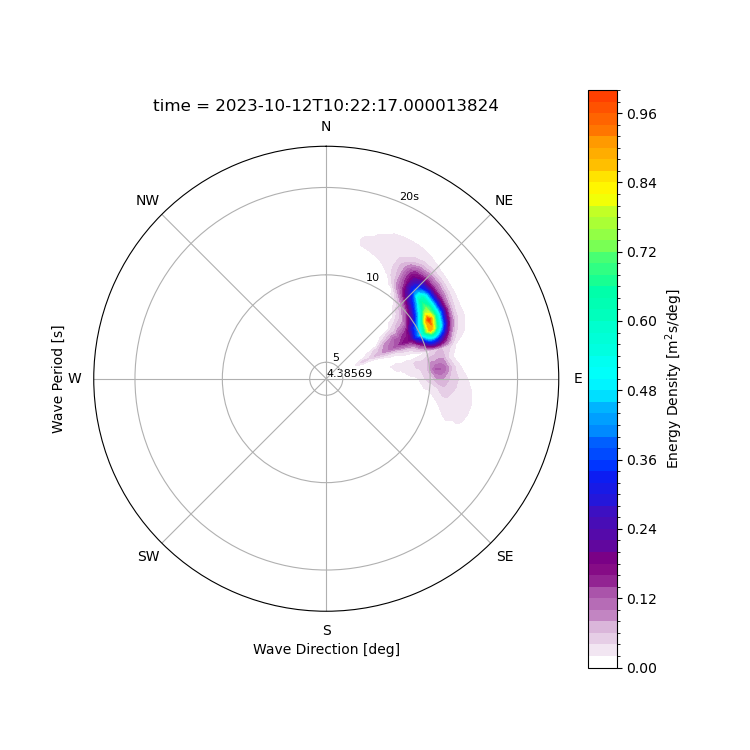

In [7]:
# plot 1st directional spectra
cmap = cmap_wavespectra(n=64)
qcs = dset_WA_ws.isel(time=0).spec.plot(
    cmap=cmap,
    as_period=True,
    as_log10=False,
    show_direction_label=True,
    levels=cmap.N,
    figsize=(7.5, 7.5),
    robuts=True,
    add_colorbar=False
)

# Set the colorbar label
cb = plt.colorbar(qcs, label="Energy Density [m$^2$s/deg]")

# Set the x-axis tick labels to compass directions
angle_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
plt.gca().set_xticklabels(angle_labels)

# Set ylabel
plt.ylabel("Wave Period [s]", labelpad=20)

# Set xlabel
plt.xlabel("Wave Direction [deg]")

# Show the plot
plt.show()

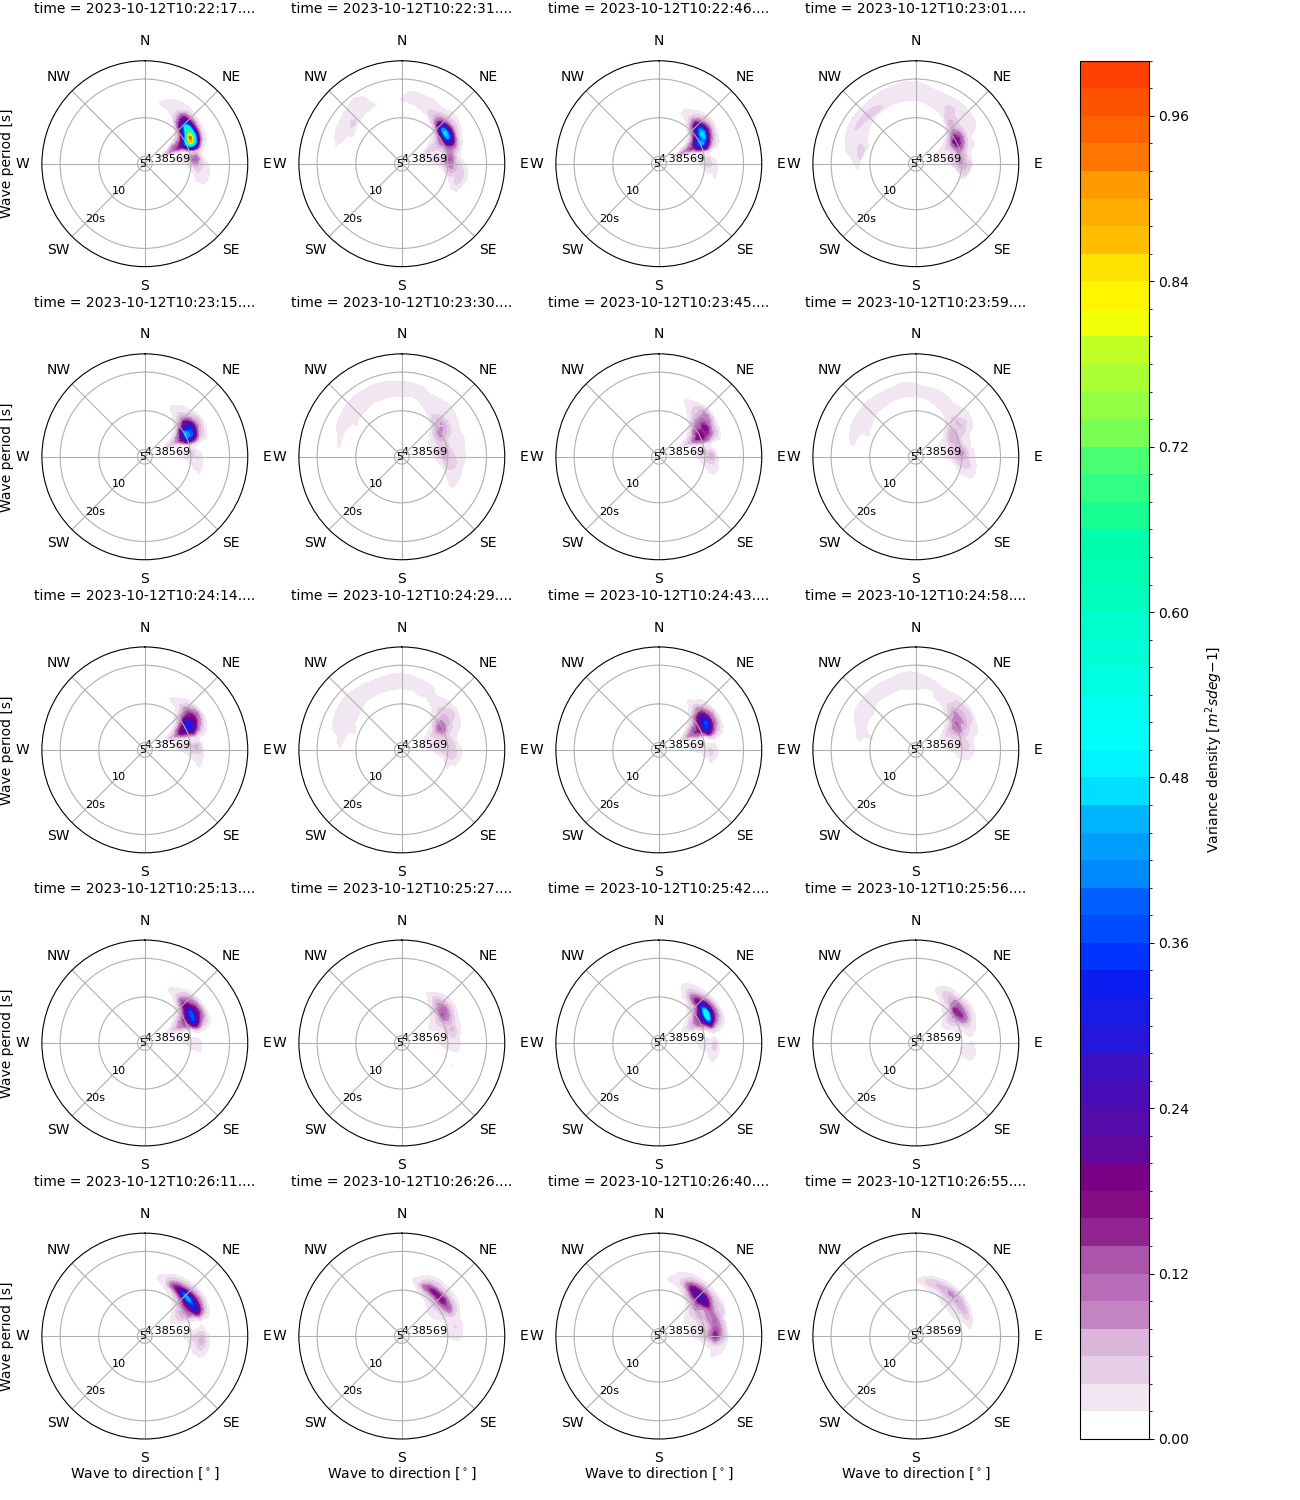

In [8]:
## plot all directional spectra
ncols = 4
fg = dset_WA_ws.efth.spec.plot(
    col = "time", 
    col_wrap = ncols, 
    cmap = cmap,
    as_period = True, as_log10 = False,
    show_direction_label = True,
    levels = cmap.N,
    robuts = True) 

angle_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W','NW']


for i, ax in enumerate(fg.axes.flat):
    ax.set_rlabel_position(180 + 45)
    ax.set_thetagrids(angles = range(0, 360, 45), labels = angle_labels)

fg.set_titles(pad = 15)
fg.set_ylabels('Wave period [s]', labelpad = 20)
fg.set_xlabels('Wave to direction [$^\circ$]', labelpad = 0)
fg.cbar.set_label('Variance density [$m^2 s deg{-1}$]', labelpad = 10)
fg.cbar.set_ticks([i * 0.12 for i in range(9)])


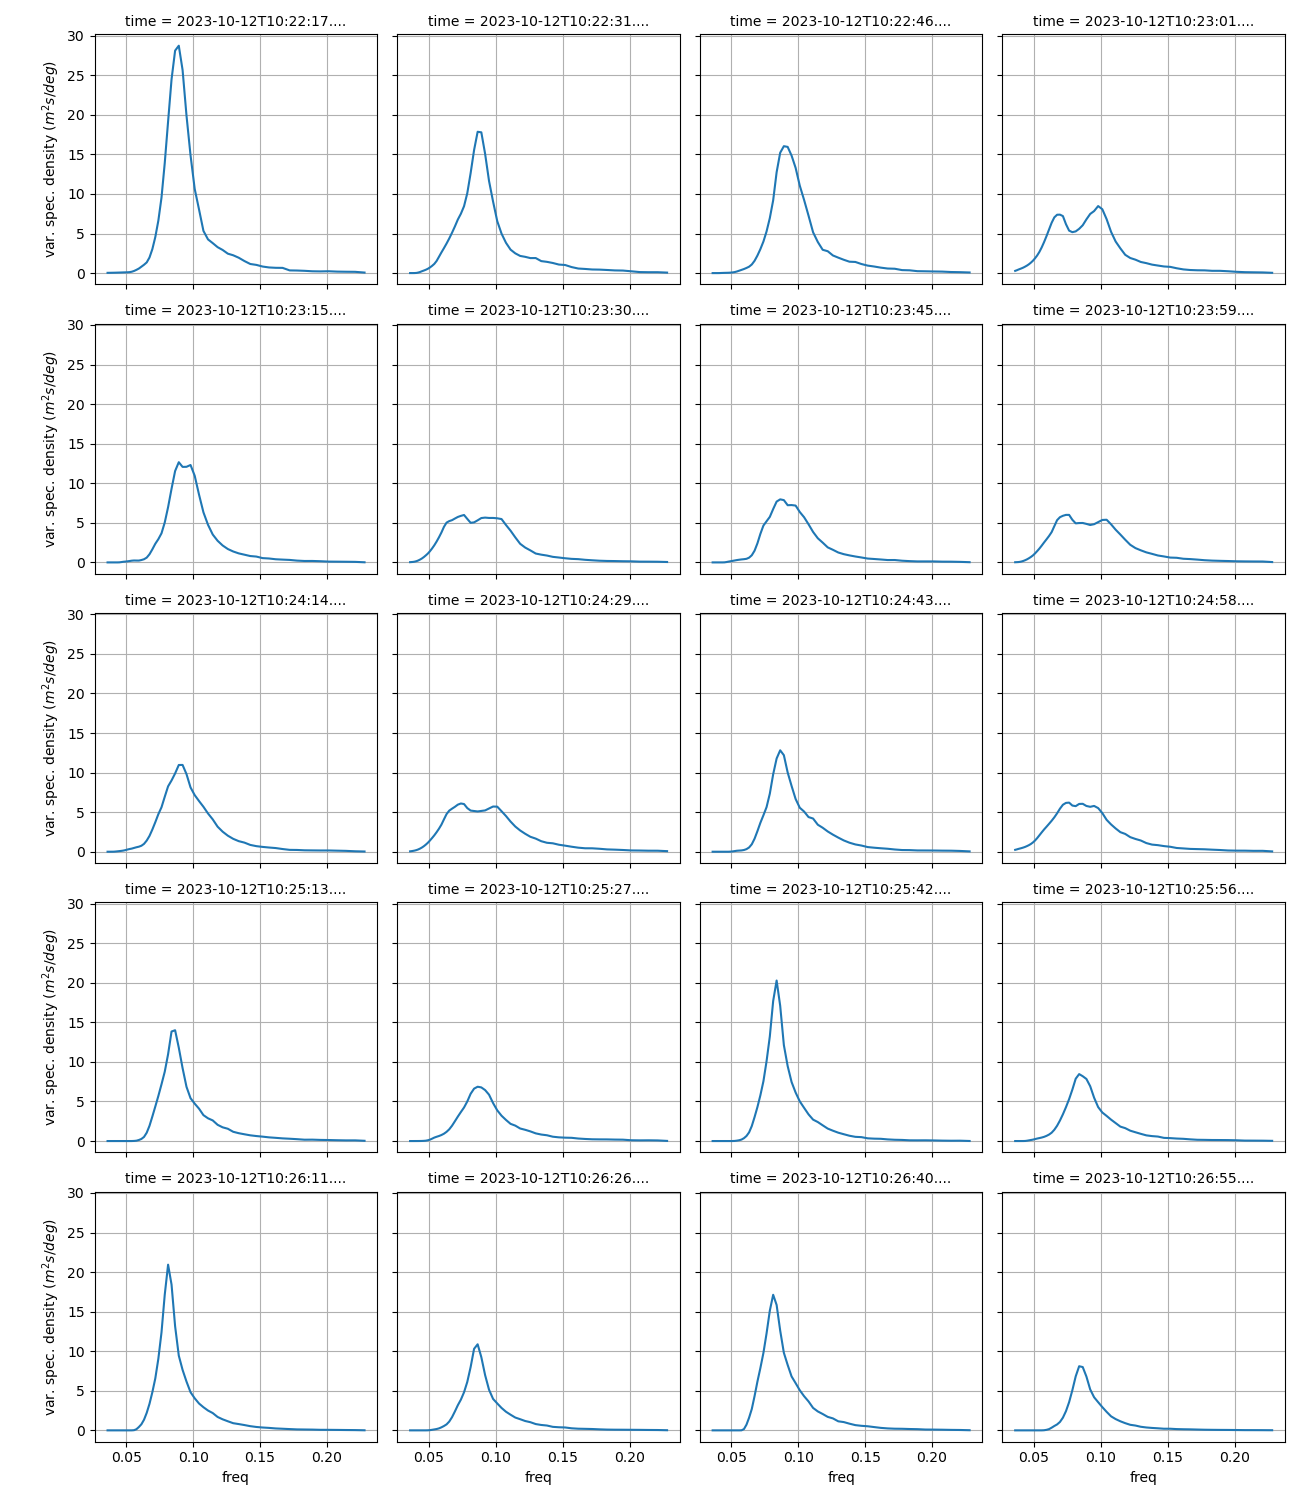

In [9]:
# plot all omni-directional spectra
ncols = 4
fg = dset_WA_ws.spec.oned().plot.line(col = 'time', col_wrap=ncols)
fg.set_ylabels('var. spec. density ($m^2s/deg$)')  # Set y-axis label
for i, ax in enumerate(fg.axes.flat):
    ax.grid(True)


### 8. Visualise directional frequency spectra swell partitions: 
- paritions of first directional spectrum
- partitions of all directional spectra

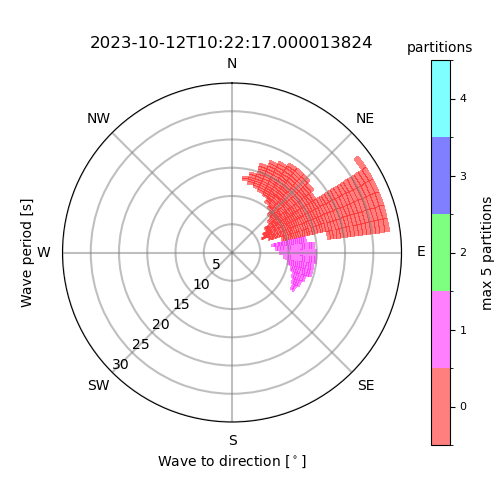

In [10]:
# plot partitions for 1st 2d spectrum
fig = plot_part(dset_WA_ws.EKTH_PART.isel(TIME = 0))

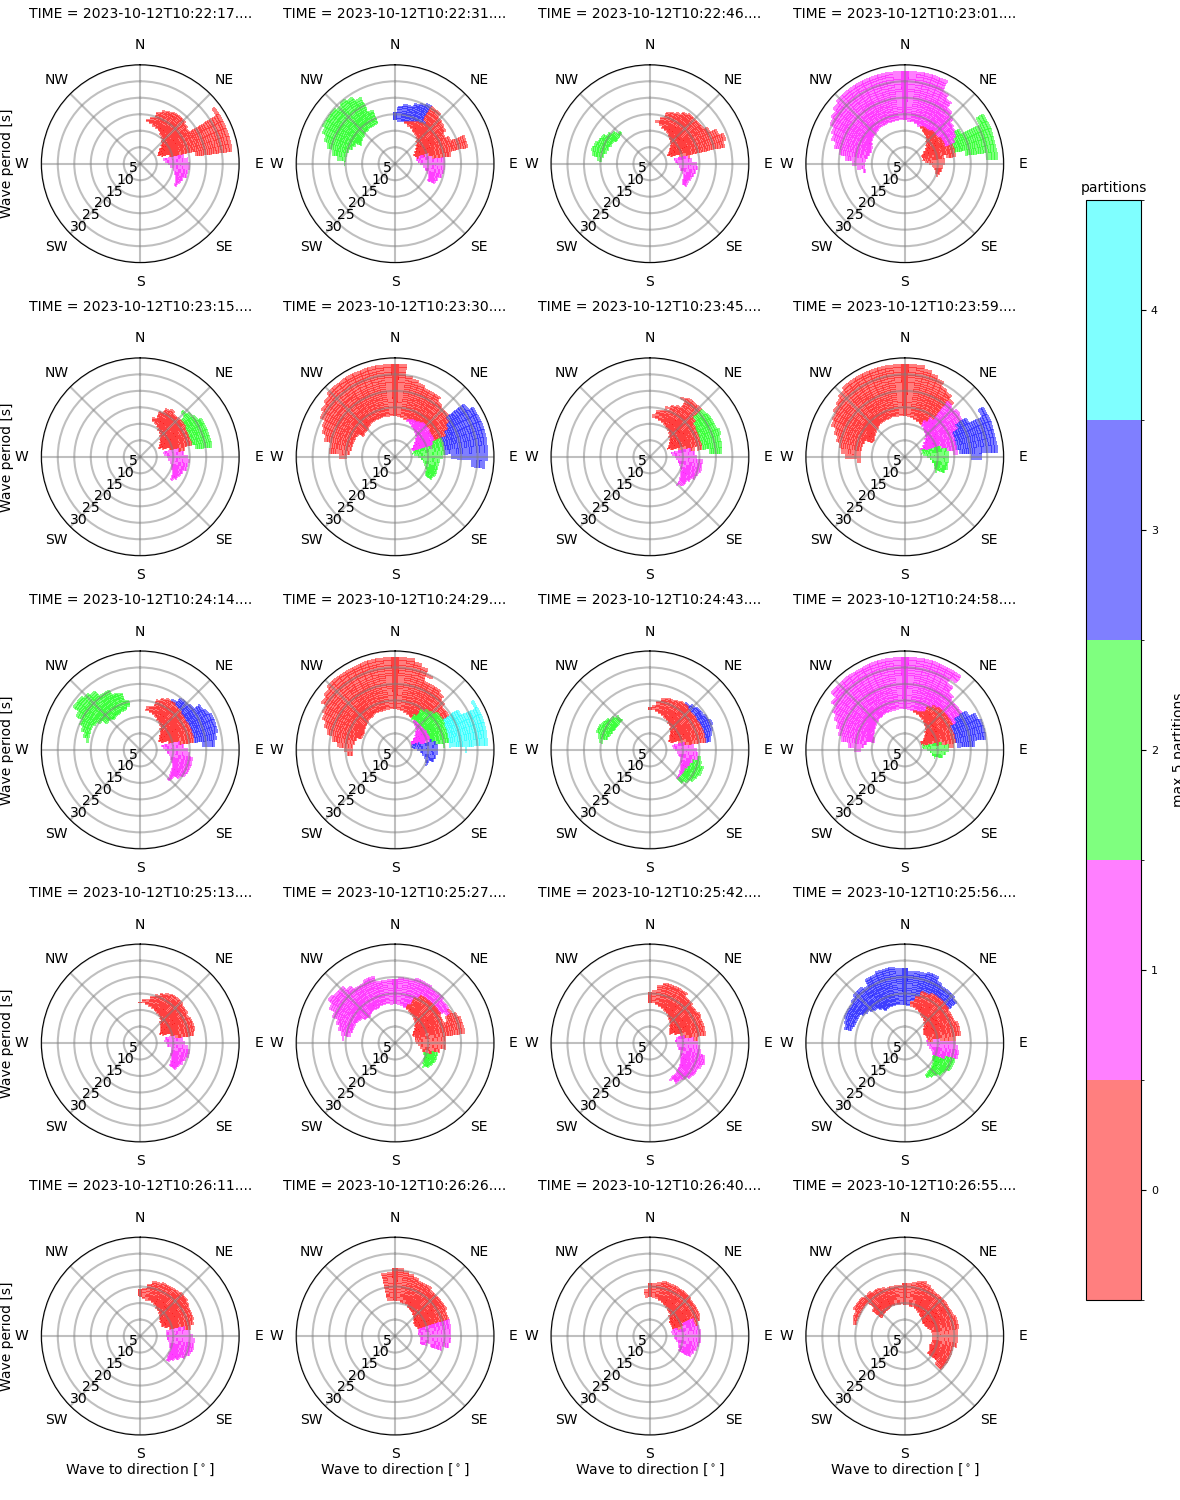

In [11]:
# plot partitions for all 2d spectra
fig = plot_part(dset_WA_ws.EKTH_PART)

### 9. Plot some primary swell wave statistics:

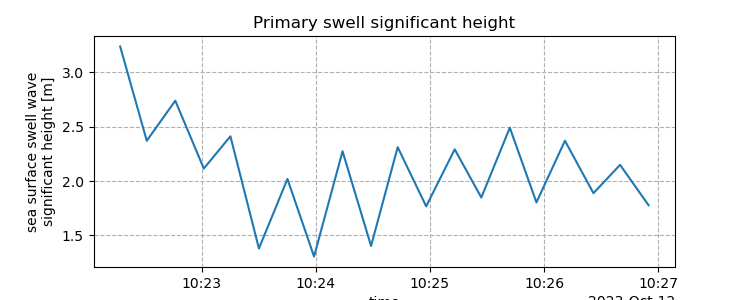

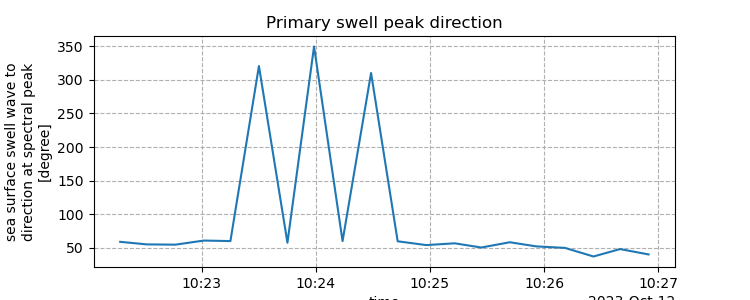

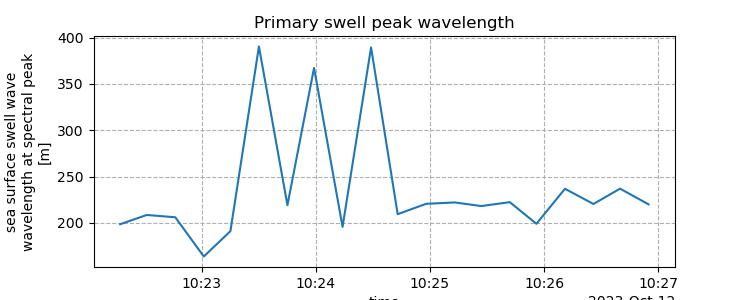

In [12]:
# plot primary swell stats
# swell height
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.HS_PART.isel(PARTITION = 0).plot()
plt.title('Primary swell significant height') 
plt.grid(linestyle = 'dashed')

# direction at spectral peak
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.DP_PART.isel(PARTITION = 0).plot()
plt.title('Primary swell peak direction') 
plt.grid(linestyle = 'dashed')

# wavelength at spectral peak
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.WP_PART.isel(PARTITION = 0).plot()
plt.title('Primary swell peak wavelength') 
plt.grid(linestyle = 'dashed')